In [39]:
import os
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd

In [40]:
file = open("hw4_tr7.pkl",'rb')
train_data = pickle.load(file)
file.close()

In [53]:
file = open("hw4_te7.pkl",'rb')
test_data = pickle.load(file)
file.close()

In [41]:
train_data.shape


(6265, 28, 28)

In [54]:
BATCH = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH)

In [61]:
# Ref : https://github.com/pytorch/examples/blob/master/vae/main.py
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
#         self.fc1 = nn.Linear(784, 400)
#         self.fc2 = nn.Linear(400, 200)
#         self.fc3 = nn.Linear(200, 100)
#         self.fc4 = nn.Linear(100, 50)
#         self.bottle = nn.Linear(50, 5)
#         self.f5 = nn.Linear(5, 50)
#         self.f6 = nn.Linear(50, 100)
#         self.fc7 = nn.Linear(100, 200)
#         self.fc8 = nn.Linear(200, 400)
#         self.fc9 = nn.Linear(400, 784)

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 5)
        self.fc22 = nn.Linear(400, 5)
        self.fc3 = nn.Linear(5, 400)
        self.fc4 = nn.Linear(400, 784)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [62]:
model = NeuralNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [63]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [64]:
def train(epoch):
    model.train()
    train_loss = 0
    for i, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print(loss.item())
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [82]:
for epoch in range(1000):
    train(epoch)

24307.953125
23869.3671875
24888.958984375
23489.95703125
23944.984375
24516.5625
24190.060546875
24309.912109375
23679.419921875
25319.791015625
24204.712890625
24595.33984375
24060.8359375
24362.76953125
24010.142578125
23799.115234375
24525.2265625
24789.896484375
24102.51171875
23851.16796875
24908.90234375
24409.720703125
24752.884765625
24957.03515625
24143.87109375
24037.94140625
24618.41015625
23729.490234375
24671.69140625
24433.5546875
23763.3046875
8139.787109375
====> Epoch: 0 Average loss: 121.5300
24045.1484375
23656.94921875
24577.65234375
23303.724609375
23799.265625
24347.01953125
24032.001953125
24169.439453125
23526.515625
25169.15625
24016.16796875
24499.197265625
23885.755859375
24167.08984375
23816.189453125
23536.96484375
24370.990234375
24596.064453125
23921.283203125
23657.044921875
24766.76953125
24183.044921875
24560.126953125
24809.732421875
23941.654296875
23930.27734375
24508.4140625
23503.669921875
24528.455078125
24361.650390625
23481.4296875
8059.331054

23275.72265625
23100.8046875
22366.783203125
7575.97900390625
====> Epoch: 15 Average loss: 113.9347
22590.91015625
22362.3046875
22997.853515625
22099.09765625
22264.267578125
22659.642578125
22753.5078125
22710.677734375
22165.763671875
23662.634765625
22641.84765625
22953.3984375
22398.1171875
22675.279296875
22516.796875
22094.560546875
23000.23046875
23088.25390625
22472.15625
22208.8984375
23298.130859375
22723.822265625
23151.072265625
23526.09765625
22681.779296875
22543.6953125
22933.33984375
22229.615234375
23140.841796875
23082.0625
22223.306640625
7621.3427734375
====> Epoch: 16 Average loss: 113.5629
22406.16015625
22377.28515625
23007.884765625
21907.94140625
22308.46484375
22594.30859375
22603.9609375
22616.87109375
22178.296875
23628.94140625
22538.33203125
22974.76953125
22372.90625
22592.810546875
22488.431640625
22047.93359375
22934.44921875
22984.1328125
22491.52734375
22185.79296875
23200.6328125
22648.7265625
23077.90234375
23474.87890625
22591.666015625
22475.900

23022.146484375
22128.0546875
21959.84765625
22266.8515625
21698.857421875
22534.775390625
22436.775390625
21728.96484375
7314.55224609375
====> Epoch: 31 Average loss: 110.5532
21864.029296875
21829.61328125
22229.8671875
21386.35546875
21615.470703125
22050.474609375
22102.796875
22090.169921875
21558.439453125
23139.658203125
21996.0859375
22305.83984375
21731.501953125
21975.384765625
21900.9375
21491.34765625
22277.52734375
22534.24609375
21964.072265625
21656.783203125
22602.783203125
22046.947265625
22587.61328125
23016.798828125
22117.599609375
21958.48828125
22248.76953125
21702.705078125
22411.650390625
22393.3671875
21709.267578125
7282.97412109375
====> Epoch: 32 Average loss: 110.4197
21686.0234375
21715.037109375
22275.39453125
21379.68359375
21554.2421875
21960.59375
22113.61328125
22016.046875
21521.21484375
23062.390625
22058.00390625
22303.375
21653.240234375
21987.234375
21873.75390625
21444.255859375
22177.912109375
22400.126953125
21887.3515625
21487.416015625
2253

21970.943359375
21510.7109375
21091.474609375
22162.109375
21713.703125
22134.494140625
22483.5234375
21745.60546875
21504.6015625
21775.9921875
21351.7109375
22009.677734375
21931.033203125
21105.931640625
7189.7158203125
====> Epoch: 47 Average loss: 108.2343
21280.23046875
21448.42578125
21837.53515625
21059.666015625
21125.041015625
21541.021484375
21665.146484375
21621.6640625
21195.001953125
22630.3515625
21616.80859375
21848.68359375
21248.921875
21538.416015625
21599.48046875
21149.6796875
21838.330078125
21969.173828125
21446.5859375
21154.96875
22153.107421875
21643.513671875
22124.662109375
22522.240234375
21760.91015625
21460.755859375
21715.173828125
21321.68359375
21923.626953125
21895.6875
21176.48828125
7157.220703125
====> Epoch: 48 Average loss: 108.1676
21267.11328125
21405.265625
21857.703125
21059.26171875
21113.8984375
21527.9765625
21663.8671875
21569.296875
21171.412109375
22614.697265625
21556.87890625
21884.21484375
21155.896484375
21436.02734375
21517.0078125

20851.7109375
21497.021484375
21678.064453125
21231.9765625
20909.41796875
21826.392578125
21399.98828125
21897.53125
22261.990234375
21468.1171875
21241.341796875
21536.34765625
21166.4140625
21664.92578125
21627.341796875
20914.560546875
7079.419921875
====> Epoch: 63 Average loss: 106.8549
21075.0390625
21138.302734375
21541.171875
20860.103515625
20903.2578125
21281.724609375
21355.306640625
21350.880859375
20982.1875
22326.490234375
21266.572265625
21639.1015625
20983.525390625
21261.87890625
21285.568359375
20801.76953125
21571.6171875
21639.138671875
21279.955078125
20886.115234375
21817.6484375
21383.671875
21860.0859375
22152.73828125
21483.931640625
21187.79296875
21455.328125
21031.078125
21696.84765625
21582.01953125
20848.21875
7016.63427734375
====> Epoch: 64 Average loss: 106.7751
21028.087890625
21188.341796875
21544.38671875
20890.12890625
20916.451171875
21296.580078125
21461.462890625
21426.24609375
20921.46484375
22325.6875
21323.544921875
21680.50390625
21016.40820

20599.384765625
21114.720703125
21447.08203125
20974.158203125
20629.76953125
21582.94921875
21153.26953125
21584.955078125
21960.615234375
21211.998046875
20920.4296875
21142.48046875
20811.66796875
21241.4453125
21288.4375
20572.96484375
6993.8828125
====> Epoch: 79 Average loss: 105.4117
20774.208984375
20841.4453125
21273.5390625
20544.794921875
20593.27734375
21060.091796875
21043.41015625
20974.9765625
20779.974609375
22087.345703125
21032.21484375
21342.61328125
20659.005859375
20919.97265625
20998.46875
20557.765625
21214.947265625
21321.115234375
20883.3046875
20519.798828125
21577.017578125
21143.80859375
21583.802734375
21973.21484375
21263.935546875
20979.201171875
21173.537109375
20793.640625
21268.38671875
21324.048828125
20592.63671875
6999.015625
====> Epoch: 80 Average loss: 105.3623
20776.671875
20835.1484375
21198.640625
20564.830078125
20596.28515625
21006.958984375
21080.19921875
21003.701171875
20688.763671875
22046.033203125
21036.3046875
21326.291015625
20671.17

20540.396484375
21853.646484375
20902.775390625
21153.3359375
20442.15234375
20799.875
20756.890625
20495.830078125
21128.580078125
21148.45703125
20697.873046875
20342.390625
21408.99609375
21002.41015625
21459.583984375
21828.345703125
21092.443359375
20900.82421875
21030.67578125
20677.587890625
21065.4765625
21105.4375
20450.021484375
6944.61328125
====> Epoch: 95 Average loss: 104.6015
20645.220703125
20762.677734375
21079.765625
20441.841796875
20474.326171875
20949.59765625
20863.490234375
20860.46484375
20519.642578125
21843.0625
20938.1953125
21269.873046875
20429.087890625
20652.828125
20803.2734375
20467.53515625
21116.5078125
21231.328125
20731.0
20396.73046875
21463.20703125
21142.482421875
21530.7421875
21783.87890625
21007.72265625
20836.732421875
21205.13671875
20812.7578125
21083.01171875
21088.6328125
20476.236328125
6971.60302734375
====> Epoch: 96 Average loss: 104.6893
20666.03125
20767.71484375
21142.044921875
20409.96875
20528.5
20956.63671875
20974.298828125
209

20673.82421875
20619.580078125
20368.625
21711.6640625
20652.833984375
20967.12890625
20260.6875
20663.78515625
20652.861328125
20213.27734375
20861.228515625
20971.61328125
20655.21875
20243.470703125
21315.92578125
20866.3984375
21269.8359375
21695.677734375
20893.4921875
20702.859375
20731.044921875
20489.8984375
20852.876953125
20925.900390625
20393.91015625
6918.0322265625
====> Epoch: 111 Average loss: 103.7193
20499.908203125
20587.1484375
20998.60546875
20298.013671875
20262.845703125
20818.93359375
20752.76953125
20693.224609375
20400.986328125
21694.845703125
20776.77734375
21036.91796875
20247.423828125
20628.5703125
20719.73828125
20279.72265625
20880.4609375
21028.5625
20681.64453125
20278.97265625
21256.21484375
20863.359375
21170.177734375
21595.220703125
20845.31640625
20663.91796875
20765.3984375
20441.61328125
20824.525390625
20874.935546875
20253.986328125
6882.37158203125
====> Epoch: 112 Average loss: 103.7515
20449.71875
20501.302734375
20920.7109375
20284.2578125

20916.26171875
20201.955078125
20127.89453125
20609.60546875
20666.798828125
20641.45703125
20334.19140625
21553.658203125
20585.369140625
20970.318359375
20189.82421875
20525.998046875
20459.306640625
20052.208984375
20792.32421875
20886.82421875
20537.64453125
20156.265625
21058.3359375
20662.59375
21134.5703125
21539.421875
20669.7890625
20525.353515625
20671.5859375
20411.107421875
20690.74609375
20910.828125
20129.640625
6846.27294921875
====> Epoch: 127 Average loss: 103.1851
20315.48046875
20475.794921875
20920.470703125
20244.21875
20149.103515625
20641.19921875
20550.59765625
20553.615234375
20321.583984375
21472.40625
20494.076171875
20861.1640625
20053.79296875
20535.8046875
20521.744140625
20021.501953125
20707.826171875
20813.05078125
20515.337890625
20116.58984375
21055.17578125
20609.80859375
21106.609375
21548.68359375
20726.931640625
20512.60546875
20603.056640625
20439.115234375
20773.365234375
20830.7734375
20067.525390625
6863.0849609375
====> Epoch: 128 Average los

====> Epoch: 142 Average loss: 102.3222
20168.48046875
20316.748046875
20682.86328125
19984.236328125
20022.37890625
20466.234375
20449.859375
20403.9921875
20220.876953125
21288.380859375
20340.08984375
20714.107421875
19949.017578125
20347.36328125
20313.55078125
19951.021484375
20551.2265625
20707.03515625
20360.044921875
19973.634765625
20909.162109375
20528.650390625
20950.0
21342.607421875
20568.51171875
20379.333984375
20454.8984375
20262.142578125
20559.0625
20522.708984375
19960.86328125
6806.5576171875
====> Epoch: 143 Average loss: 102.2276
20090.48046875
20268.111328125
20666.212890625
20053.1484375
19922.142578125
20377.748046875
20396.267578125
20440.734375
20229.25390625
21286.462890625
20333.458984375
20745.28125
20065.48046875
20328.669921875
20321.24609375
19906.2109375
20609.203125
20683.345703125
20263.421875
20019.146484375
20938.814453125
20520.31640625
20829.89453125
21380.91015625
20564.58203125
20317.91015625
20435.228515625
20275.9140625
20554.716796875
20646.

20617.55078125
19865.978515625
6810.1337890625
====> Epoch: 158 Average loss: 102.3892
20310.1015625
20601.91015625
20826.595703125
19999.62890625
19901.765625
20516.544921875
20539.7109375
20653.62109375
20248.98828125
21321.427734375
20380.4375
20893.119140625
20238.369140625
20416.6328125
20292.072265625
20040.421875
20605.38671875
20806.57421875
20489.96875
20055.08984375
20920.404296875
20481.966796875
20972.48828125
21546.875
20678.30859375
20364.39453125
20366.6953125
20207.484375
20541.505859375
20618.55859375
19977.06640625
6837.775390625
====> Epoch: 159 Average loss: 102.5781
20008.888671875
20327.421875
20683.294921875
20001.71875
19929.009765625
20376.791015625
20343.705078125
20391.982421875
20185.876953125
21292.83984375
20272.96875
20655.080078125
20002.181640625
20251.08984375
20252.85546875
19824.16015625
20471.62890625
20655.771484375
20351.982421875
19948.51171875
20826.388671875
20553.322265625
20827.578125
21337.5078125
20509.908203125
20310.025390625
20433.244140

20209.173828125
20009.4140625
20235.126953125
20316.57421875
19715.341796875
6722.13232421875
====> Epoch: 174 Average loss: 101.0573
19880.125
19987.80859375
20373.4296875
19878.1875
19809.841796875
20190.255859375
20126.197265625
20123.8671875
19973.32421875
21039.0078125
20084.98828125
20427.298828125
19783.05859375
20090.18359375
20012.9140625
19671.357421875
20306.990234375
20410.83984375
20063.962890625
19865.337890625
20709.39453125
20279.447265625
20646.6015625
21176.388671875
20296.939453125
20102.7578125
20164.97265625
19941.8203125
20217.291015625
20304.892578125
19786.115234375
6727.39453125
====> Epoch: 175 Average loss: 100.9502
19811.26953125
20001.98828125
20518.681640625
19773.5
19819.583984375
20198.95703125
20161.748046875
20128.666015625
19948.0703125
21048.953125
20143.33203125
20553.205078125
19726.716796875
20115.47265625
20061.5234375
19669.19921875
20334.0234375
20474.8828125
20056.07421875
19764.240234375
20597.478515625
20275.25
20610.298828125
21102.47460937

21067.556640625
20223.306640625
20028.69140625
20149.08984375
19975.5859375
20248.8671875
20243.76171875
19699.107421875
6731.6181640625
====> Epoch: 190 Average loss: 100.7501
19848.4921875
20014.623046875
20394.591796875
19734.21875
19744.271484375
20149.40234375
20092.744140625
20126.365234375
19915.125
20987.171875
20129.587890625
20439.69921875
19679.69921875
20016.755859375
19951.16796875
19670.779296875
20299.4375
20415.51953125
20104.5703125
19651.63671875
20687.33203125
20281.6953125
20564.32421875
21041.4453125
20238.693359375
20080.080078125
20156.3671875
20029.87890625
20152.9921875
20239.75390625
19730.177734375
6706.5615234375
====> Epoch: 191 Average loss: 100.7622
19809.296875
19971.8203125
20331.958984375
19784.93359375
19758.904296875
20144.447265625
20068.849609375
20086.169921875
19998.685546875
21037.23046875
20177.462890625
20387.8515625
19696.927734375
20037.2734375
19995.5859375
19612.984375
20271.470703125
20367.6015625
20023.890625
19658.1640625
20630.94335937

20027.541015625
20081.8125
19901.36328125
20152.78125
20205.328125
19698.5859375
6724.1767578125
====> Epoch: 206 Average loss: 100.4153
19760.19140625
19939.94140625
20273.361328125
19704.228515625
19682.828125
20175.126953125
19973.623046875
20111.505859375
19890.0546875
20887.0546875
20004.685546875
20283.96875
19683.56640625
19955.78125
19855.279296875
19539.302734375
20131.8828125
20255.529296875
19906.9453125
19665.876953125
20619.140625
20221.11328125
20436.03515625
20918.185546875
20240.193359375
20036.294921875
20024.939453125
19886.8125
20070.16015625
20141.505859375
19753.23046875
6714.0556640625
====> Epoch: 207 Average loss: 100.3579
19772.64453125
19875.685546875
20281.994140625
19693.169921875
19645.865234375
20023.859375
19976.203125
20007.091796875
19841.25390625
20930.2890625
20001.70703125
20290.91015625
19600.1171875
19996.927734375
19958.205078125
19604.228515625
20132.53125
20258.80859375
19940.818359375
19634.734375
20624.6015625
20150.822265625
20434.107421875
2

20539.05078125
20119.1875
20465.703125
20976.67578125
20098.873046875
19916.884765625
20007.02734375
19891.0546875
19982.3984375
20133.21484375
19637.51171875
6699.57958984375
====> Epoch: 222 Average loss: 100.0547
19788.01171875
19871.45703125
20204.208984375
19621.171875
19672.59765625
20126.76171875
19951.80859375
20009.841796875
19797.3359375
20841.404296875
20013.853515625
20264.3515625
19549.4140625
19965.869140625
19879.328125
19564.37109375
20179.328125
20311.490234375
19861.888671875
19672.498046875
20550.5234375
20118.451171875
20390.869140625
21001.615234375
20156.38671875
19964.73828125
19954.96875
19866.8203125
19970.21875
20154.412109375
19587.029296875
6694.73681640625
====> Epoch: 223 Average loss: 100.1688
19693.697265625
19791.62890625
20187.408203125
19656.65625
19577.841796875
19988.826171875
19918.5390625
19992.349609375
19773.888671875
20857.166015625
19986.05859375
20325.970703125
19547.31640625
19937.890625
19884.767578125
19527.21875
20102.802734375
20225.6289

20032.107421875
20126.28515625
19863.666015625
19556.595703125
20445.25390625
20005.439453125
20358.228515625
20918.140625
20048.240234375
19938.47265625
19974.458984375
19801.822265625
19942.759765625
20086.9296875
19582.16796875
6681.54541015625
====> Epoch: 238 Average loss: 99.7101
19745.30078125
19847.361328125
20204.94921875
19571.2265625
19480.634765625
19947.8671875
19897.90234375
19953.095703125
19754.97265625
20721.982421875
19950.39453125
20145.86328125
19421.888671875
19867.6171875
19805.04296875
19464.4453125
20067.794921875
20130.95703125
19794.365234375
19420.12109375
20387.85546875
20032.228515625
20325.9765625
20869.359375
19990.8125
19911.64453125
19903.06640625
19763.1953125
19937.45703125
19939.71484375
19550.001953125
6707.9658203125
====> Epoch: 239 Average loss: 99.6829
19621.423828125
19775.349609375
20120.80078125
19518.330078125
19583.21484375
19899.2890625
19818.92578125
19851.912109375
19702.087890625
20663.00390625
19866.966796875
20173.06640625
19430.47851

19775.16015625
19787.50390625
20783.30859375
19820.72265625
20122.705078125
19373.78125
19744.927734375
19724.013671875
19494.419921875
20027.90234375
20039.125
19757.865234375
19414.052734375
20387.4921875
19962.646484375
20274.6953125
20837.34765625
19999.74609375
19860.837890625
19909.158203125
19724.572265625
19860.52734375
19937.58203125
19449.763671875
6682.68603515625
====> Epoch: 254 Average loss: 99.4394
19614.68359375
19757.1171875
20072.634765625
19535.59375
19477.57421875
19893.515625
19803.45703125
19830.244140625
19661.041015625
20725.15625
19827.498046875
20117.646484375
19417.67578125
19698.29296875
19643.078125
19450.455078125
20034.5234375
20150.70703125
19805.96875
19410.765625
20408.26171875
19979.1328125
20235.65234375
20810.935546875
19968.203125
19843.76171875
19913.03515625
19767.12890625
19885.107421875
19947.173828125
19546.087890625
6697.67919921875
====> Epoch: 255 Average loss: 99.4301
19654.69140625
19757.912109375
20141.974609375
19554.173828125
19510.292

20086.271484375
19568.490234375
19663.876953125
20032.9609375
19944.716796875
19988.9140625
19717.3515625
20741.384765625
19964.236328125
20371.74609375
19646.779296875
19886.625
19834.52734375
19680.396484375
20069.341796875
20310.6328125
19796.126953125
19499.890625
20648.0078125
20341.861328125
20571.279296875
20882.41015625
20062.86328125
19985.251953125
19968.1953125
19923.771484375
20063.3828125
20188.982421875
19668.140625
6697.52099609375
====> Epoch: 270 Average loss: 100.1354
19735.65234375
19881.33984375
20246.767578125
19581.26953125
19570.46484375
20015.392578125
20033.681640625
19972.751953125
19704.427734375
20695.158203125
19860.625
20237.5390625
19604.681640625
19971.650390625
19793.78125
19457.943359375
20130.716796875
20218.76953125
19880.658203125
19557.15625
20572.328125
20214.40625
20450.90234375
21046.658203125
19976.48828125
19799.734375
19853.64453125
19785.8125
20054.392578125
20223.609375
19637.66796875
6687.69384765625
====> Epoch: 271 Average loss: 99.9926


====> Epoch: 285 Average loss: 99.7788
19569.62109375
19780.56640625
20211.154296875
19791.544921875
19513.453125
19903.359375
19742.62109375
19810.47265625
19639.984375
20826.279296875
19916.78515625
20254.55078125
19461.537109375
19765.919921875
19675.416015625
19393.98046875
19977.6640625
20190.23046875
19818.634765625
19640.06640625
20487.1328125
20019.93359375
20260.03515625
20687.75
19908.314453125
19875.42578125
19912.212890625
19805.134765625
19934.501953125
19994.71875
19497.80859375
6606.57275390625
====> Epoch: 286 Average loss: 99.5807
19539.361328125
19831.115234375
20179.9375
19762.9453125
19647.529296875
19940.08984375
19678.125
19692.076171875
19621.533203125
20699.44140625
19852.5859375
20257.1640625
19598.40625
19818.9296875
19661.58203125
19340.12890625
19969.06640625
20155.005859375
19828.4375
19594.72265625
20436.9296875
20044.931640625
20145.71875
20760.876953125
19923.80859375
19780.19921875
20010.390625
19811.294921875
19972.453125
20022.474609375
19433.85742187

19873.84375
19976.345703125
19646.826171875
6689.7255859375
====> Epoch: 301 Average loss: 99.1455
19562.404296875
19732.91796875
19974.98046875
19503.4140625
19400.21875
19875.998046875
19752.787109375
19709.08203125
19608.57421875
20513.337890625
19718.8203125
19998.53515625
19297.830078125
19728.328125
19574.8359375
19333.1015625
20010.91796875
19971.740234375
19607.37109375
19372.30859375
20325.28125
20044.720703125
20262.93359375
20754.5546875
19885.5546875
19729.9296875
19723.267578125
19600.337890625
19882.375
19955.560546875
19549.22265625
6661.861328125
====> Epoch: 302 Average loss: 99.0619
19622.6796875
19764.0390625
19926.978515625
19526.552734375
19503.3125
19853.880859375
19794.4375
19748.17578125
19618.6171875
20559.947265625
19725.466796875
20009.357421875
19324.28125
19722.244140625
19542.77734375
19323.791015625
19839.98828125
20074.7421875
19601.07421875
19350.1796875
20338.3671875
19924.224609375
20240.88671875
20707.33203125
19891.978515625
19737.5546875
19678.9492

19849.279296875
19720.529296875
19733.24609375
19531.01171875
19666.98828125
19778.484375
19457.91015625
6623.86328125
====> Epoch: 317 Average loss: 98.7021
19424.263671875
19773.767578125
20077.525390625
19607.77734375
19269.36328125
19653.6484375
19582.640625
19695.30859375
19621.4140625
20622.806640625
19752.201171875
19996.03515625
19253.83984375
19644.556640625
19491.15625
19306.5
19942.33203125
20040.44140625
19717.7109375
19306.814453125
20144.9140625
19743.80078125
20034.16796875
20603.67578125
19898.859375
19798.0
19758.2421875
19547.03125
19654.9140625
19726.30859375
19349.55078125
6579.56005859375
====> Epoch: 318 Average loss: 98.7421
19494.921875
19697.4453125
19987.71484375
19501.439453125
19332.9921875
19637.12109375
19587.984375
19646.609375
19598.05078125
20525.078125
19689.38671875
19923.076171875
19216.46484375
19564.685546875
19388.55859375
19216.9140625
19943.244140625
20030.34765625
19575.33203125
19309.431640625
20194.375
19816.998046875
20051.333984375
20660.50

19716.2109375
19637.083984375
19638.33203125
19540.955078125
19626.5390625
19769.140625
19229.9921875
6615.009765625
====> Epoch: 333 Average loss: 98.3460
19373.359375
19526.12109375
19890.755859375
19372.181640625
19337.90234375
19653.849609375
19584.669921875
19662.681640625
19445.34765625
20369.91796875
19651.08203125
19993.75
19253.455078125
19610.126953125
19468.681640625
19155.77734375
19738.771484375
19942.34375
19581.25
19255.939453125
20241.072265625
19751.724609375
20000.716796875
20569.05078125
19702.310546875
19605.013671875
19661.73046875
19591.046875
19663.25
19749.6640625
19249.9921875
6586.833984375
====> Epoch: 334 Average loss: 98.3624
19410.955078125
19565.125
19848.107421875
19354.705078125
19307.220703125
19610.48828125
19616.7578125
19555.46484375
19531.33984375
20357.662109375
19652.06640625
19842.205078125
19164.6171875
19560.494140625
19381.283203125
19204.666015625
19760.80078125
19864.28125
19424.794921875
19217.31640625
20207.640625
19696.8046875
20003.9121

19948.330078125
20513.89453125
19712.9140625
19516.3046875
19546.6484375
19485.791015625
19655.23046875
19722.609375
19225.98828125
6577.3623046875
====> Epoch: 349 Average loss: 98.1030
19362.44140625
19508.43359375
19823.80859375
19337.5078125
19225.927734375
19680.015625
19463.982421875
19505.927734375
19441.41796875
20433.212890625
19656.666015625
19787.55078125
19125.681640625
19465.10546875
19361.6484375
19085.51953125
19704.078125
19871.8671875
19553.224609375
19247.263671875
20161.021484375
19661.833984375
19965.279296875
20552.78515625
19702.673828125
19504.736328125
19614.490234375
19414.47265625
19568.759765625
19617.828125
19219.873046875
6585.0068359375
====> Epoch: 350 Average loss: 98.0383
19378.62109375
19549.20703125
19845.30859375
19330.888671875
19223.703125
19599.033203125
19450.212890625
19481.921875
19430.609375
20356.984375
19560.078125
19909.984375
19128.09765625
19573.06640625
19371.609375
19135.884765625
19731.048828125
19895.75
19523.234375
19214.7890625
2019

19411.09375
20224.77734375
19833.39453125
19936.921875
20518.021484375
19704.876953125
19526.6171875
19710.11328125
19494.0
19684.287109375
19699.3359375
19206.296875
6574.255859375
====> Epoch: 365 Average loss: 98.3219
19281.1328125
19593.310546875
19926.17578125
19433.68359375
19324.3125
19618.546875
19454.73828125
19552.349609375
19461.69140625
20457.265625
19664.02734375
19899.99609375
19135.990234375
19650.177734375
19556.734375
19113.390625
19771.455078125
19862.26953125
19562.36328125
19305.078125
20319.6015625
19764.798828125
19996.248046875
20526.6796875
19682.458984375
19515.3515625
19618.77734375
19558.115234375
19776.869140625
19880.390625
19344.65234375
6577.060546875
====> Epoch: 366 Average loss: 98.3537
19369.80859375
19511.42578125
19831.236328125
19455.728515625
19417.927734375
19666.203125
19592.15625
19520.060546875
19417.046875
20447.662109375
19731.962890625
19932.416015625
19332.298828125
19679.015625
19441.75390625
19150.697265625
19740.56640625
19891.990234375

19778.94921875
19562.248046875
19370.107421875
19941.837890625
20107.498046875
19675.44921875
19471.99609375
20440.388671875
19914.462890625
19994.6015625
20674.283203125
20032.55859375
19892.189453125
19829.07421875
19667.921875
19716.35546875
19885.79296875
19662.310546875
6673.1669921875
====> Epoch: 381 Average loss: 99.3172
19658.130859375
19840.099609375
19994.818359375
19608.9609375
19513.296875
19793.14453125
19730.234375
19685.41796875
19664.1484375
20641.57421875
19829.70703125
20068.08984375
19343.63671875
19767.814453125
19642.3671875
19327.30859375
19825.828125
20068.8046875
19611.9296875
19353.08203125
20434.55859375
19774.61328125
20096.681640625
20579.33984375
19912.505859375
19822.537109375
19649.837890625
19555.328125
19783.7421875
19824.3359375
19354.5703125
6641.59423828125
====> Epoch: 382 Average loss: 99.0260
19659.53125
19776.08203125
20044.158203125
19509.078125
19400.228515625
19649.30859375
19650.357421875
19676.115234375
19640.62890625
20553.7890625
19718.63

20386.03515625
19542.91796875
19826.287109375
19040.2109375
19442.1640625
19236.34765625
18945.111328125
19482.41796875
19826.017578125
19386.75
19091.83203125
20061.109375
19650.5859375
19833.44140625
20377.7578125
19534.048828125
19445.916015625
19499.423828125
19368.22265625
19467.564453125
19522.203125
19124.365234375
6523.4326171875
====> Epoch: 397 Average loss: 97.5643
19195.611328125
19449.81640625
19712.359375
19210.6796875
19193.12109375
19550.53125
19329.12890625
19380.68359375
19339.046875
20315.83984375
19516.88671875
19684.060546875
19008.947265625
19399.7109375
19234.62109375
19015.087890625
19580.24609375
19775.0625
19428.796875
19163.65625
20036.67578125
19561.03515625
19771.951171875
20432.513671875
19563.267578125
19411.18359375
19558.666015625
19331.470703125
19410.677734375
19540.650390625
19110.9921875
6557.9228515625
====> Epoch: 398 Average loss: 97.4894
19206.5703125
19349.50390625
19706.060546875
19287.88671875
19188.265625
19549.259765625
19361.01171875
19349

19515.443359375
19380.474609375
19382.5859375
19299.02734375
20265.099609375
19391.0078125
19636.73046875
18950.70703125
19417.1171875
19209.951171875
18991.94140625
19495.306640625
19718.314453125
19277.78515625
19050.494140625
19993.91015625
19579.734375
19738.03515625
20282.103515625
19480.01171875
19412.744140625
19321.603515625
19211.13671875
19515.00390625
19519.56640625
19154.41015625
6549.0888671875
====> Epoch: 413 Average loss: 97.2297
19138.634765625
19367.14453125
19680.751953125
19214.462890625
19157.8515625
19461.208984375
19304.52734375
19333.234375
19298.56640625
20219.7890625
19405.974609375
19633.865234375
18949.83984375
19322.220703125
19175.32421875
18905.451171875
19504.994140625
19668.828125
19321.453125
19057.3984375
19986.0703125
19584.3125
19763.23046875
20276.03515625
19474.033203125
19381.2109375
19359.7421875
19187.109375
19412.240234375
19442.4609375
19069.62109375
6531.47314453125
====> Epoch: 414 Average loss: 97.1411
19140.171875
19379.98828125
19649.232

19247.462890625
19326.248046875
19310.69140625
20160.65234375
19414.662109375
19667.86328125
18955.109375
19434.8828125
19257.146484375
19023.259765625
19509.078125
19715.21484375
19277.365234375
19056.318359375
20085.28125
19652.39453125
19869.95703125
20317.84375
19384.5
19385.345703125
19483.35546875
19366.353515625
19448.15625
19431.5
19068.98828125
6525.837890625
====> Epoch: 429 Average loss: 97.2470
19291.859375
19420.0859375
19686.134765625
19175.126953125
19117.814453125
19479.5234375
19391.51171875
19426.16015625
19273.671875
20155.6171875
19443.09765625
19642.845703125
18980.6484375
19320.79296875
19230.04296875
18932.173828125
19542.888671875
19625.7734375
19251.83203125
19090.3984375
20037.90234375
19763.41796875
19881.056640625
20371.521484375
19428.00390625
19380.56640625
19516.96875
19397.5390625
19479.3046875
19530.578125
19150.84375
6520.82373046875
====> Epoch: 430 Average loss: 97.3562
19176.93359375
19427.21875
19729.52734375
19136.443359375
19104.173828125
19458.0

19643.078125
19211.533203125
19058.2421875
19499.765625
19353.328125
19334.94921875
19279.84765625
20091.919921875
19390.59765625
19626.59375
19097.60546875
19453.58984375
19237.515625
18988.130859375
19546.0078125
19627.21875
19290.568359375
19057.177734375
20006.751953125
19558.0703125
19748.77734375
20229.7265625
19431.7578125
19327.23046875
19305.435546875
19156.478515625
19354.130859375
19463.296875
19143.111328125
6560.298828125
====> Epoch: 445 Average loss: 97.1291
19229.01953125
19341.9375
19593.748046875
19132.94921875
19085.3984375
19537.341796875
19405.625
19339.34765625
19291.861328125
20138.83203125
19308.197265625
19637.220703125
18988.80078125
19473.57421875
19203.208984375
18988.7734375
19482.345703125
19689.013671875
19227.77734375
19024.984375
20080.59765625
19601.9921875
19801.7421875
20305.380859375
19432.654296875
19286.7421875
19290.8125
19172.08984375
19413.49609375
19551.287109375
19193.845703125
6514.0146484375
====> Epoch: 446 Average loss: 97.1691
19079.6347

====> Epoch: 460 Average loss: 99.2338
19902.80859375
20022.888671875
20188.203125
19693.22265625
19550.95703125
19656.3984375
19593.37109375
19585.076171875
19792.4453125
20851.09765625
19970.365234375
20105.4453125
19288.869140625
19653.41015625
19352.412109375
19221.15234375
20063.1484375
20121.94140625
19854.3359375
19541.666015625
20439.76171875
19881.8828125
20078.5859375
20544.30078125
19934.69140625
20039.2578125
19982.958984375
19789.02734375
19911.71875
19903.009765625
19441.53515625
6654.970703125
====> Epoch: 461 Average loss: 99.3792
19879.25
20249.26171875
20513.12890625
19788.8671875
19753.958984375
19808.236328125
19728.0390625
19738.529296875
19827.48046875
20815.91015625
20141.64453125
20230.544921875
19521.611328125
19839.34765625
19487.34765625
19257.330078125
20025.75390625
20238.111328125
19841.7734375
19790.2109375
20508.3515625
19976.865234375
20093.7421875
20607.7421875
19948.375
20082.9609375
20019.728515625
19859.4140625
20064.58984375
20074.119140625
19534.0

6521.7119140625
====> Epoch: 476 Average loss: 97.4741
19195.00390625
19358.439453125
19687.6875
19350.1953125
19270.18359375
19493.341796875
19255.41015625
19313.80078125
19256.734375
20207.0078125
19423.052734375
19737.84765625
19004.078125
19465.744140625
19203.1640625
18932.51953125
19598.9375
19744.849609375
19347.95703125
19262.921875
20143.224609375
19584.166015625
19828.833984375
20258.27734375
19515.953125
19455.224609375
19507.4375
19381.13671875
19536.66796875
19551.544921875
19121.66796875
6544.23583984375
====> Epoch: 477 Average loss: 97.4521
19188.23046875
19466.283203125
19681.79296875
19335.693359375
19152.185546875
19406.029296875
19323.197265625
19297.697265625
19309.787109375
20142.076171875
19412.24609375
19731.908203125
19045.1171875
19481.23046875
19221.880859375
18924.92578125
19424.82421875
19736.140625
19254.451171875
19113.19140625
20029.8515625
19520.8984375
19787.7578125
20254.255859375
19458.595703125
19433.859375
19428.591796875
19287.57421875
19494.44140

19048.69921875
6504.01318359375
====> Epoch: 492 Average loss: 96.4814
19070.69921875
19192.830078125
19443.462890625
19061.568359375
19017.955078125
19347.90234375
19311.994140625
19255.142578125
19179.091796875
20034.43359375
19246.7265625
19495.517578125
18845.58203125
19254.314453125
19091.96875
18766.42578125
19407.283203125
19568.66796875
19093.48046875
18887.4140625
19815.927734375
19377.08984375
19653.244140625
20177.78125
19425.921875
19240.984375
19191.658203125
19086.23046875
19226.955078125
19331.916015625
18999.5546875
6458.349609375
====> Epoch: 493 Average loss: 96.4977
19074.076171875
19170.83984375
19389.55078125
18970.515625
18937.890625
19246.890625
19156.78125
19258.193359375
19231.095703125
19980.404296875
19273.68359375
19497.2734375
18859.57421875
19286.3671875
19067.365234375
18788.66796875
19399.947265625
19553.0078125
19112.89453125
18886.826171875
19800.521484375
19482.685546875
19648.3671875
20153.32421875
19323.091796875
19210.337890625
19217.05859375
19049

19166.21875
18974.60546875
19223.84765625
19288.73828125
18941.29296875
6481.9169921875
====> Epoch: 508 Average loss: 96.2729
19027.88671875
19178.2265625
19456.58203125
19070.2265625
18865.59375
19273.583984375
19130.197265625
19241.5859375
19153.1796875
20092.490234375
19248.32421875
19423.8203125
18784.70703125
19173.2421875
19012.177734375
18792.58984375
19361.74609375
19505.419921875
19112.986328125
18837.52734375
19758.5234375
19358.505859375
19570.486328125
20087.509765625
19344.17578125
19176.017578125
19151.650390625
18994.6796875
19154.685546875
19262.01953125
18939.73828125
6491.1611328125
====> Epoch: 509 Average loss: 96.2540
18949.1640625
19134.244140625
19379.515625
18967.275390625
18895.609375
19221.61328125
19167.28125
19148.21484375
19118.16796875
20087.263671875
19245.95703125
19371.15234375
18773.25390625
19175.509765625
18964.80859375
18789.931640625
19390.115234375
19535.73828125
19121.125
18906.5390625
19757.662109375
19347.408203125
19586.150390625
20037.425781

19536.732421875
20054.166015625
19336.212890625
19237.888671875
19217.85546875
19023.33984375
19194.685546875
19247.50390625
18868.1171875
6488.13330078125
====> Epoch: 524 Average loss: 96.1867
19077.5390625
19247.69921875
19432.421875
18955.15625
18918.255859375
19213.33203125
19083.32421875
19218.451171875
19077.53125
20010.478515625
19256.0234375
19527.37109375
18788.974609375
19158.35546875
18988.142578125
18766.259765625
19414.40234375
19592.412109375
19102.578125
18826.142578125
19717.27734375
19301.126953125
19603.609375
20125.40234375
19241.916015625
19209.482421875
19220.900390625
19032.302734375
19175.412109375
19308.001953125
18898.27734375
6455.99951171875
====> Epoch: 525 Average loss: 96.2402
19125.87890625
19230.111328125
19467.021484375
19028.49609375
18894.541015625
19183.517578125
19097.361328125
19195.01171875
19131.91796875
19902.5859375
19251.099609375
19431.1015625
18799.591796875
19166.783203125
18995.673828125
18684.0859375
19307.2734375
19595.978515625
19152.3

19959.619140625
19488.322265625
19636.576171875
20041.564453125
19319.578125
19214.18359375
19387.21875
19193.8828125
19355.220703125
19376.498046875
18973.619140625
6490.275390625
====> Epoch: 540 Average loss: 96.7572
19119.625
19268.51953125
19618.021484375
19139.99609375
18972.25
19288.77734375
19175.42578125
19177.30859375
19141.943359375
20016.671875
19288.525390625
19609.119140625
18921.515625
19389.43359375
19090.333984375
18740.3125
19392.396484375
19676.26171875
19275.37890625
19087.357421875
19935.05078125
19449.833984375
19620.19921875
20079.046875
19311.6328125
19383.16796875
19317.90625
19195.98828125
19443.53515625
19485.0859375
18973.26953125
6472.19921875
====> Epoch: 541 Average loss: 96.7368
19050.0
19312.431640625
19588.21875
19215.7421875
19056.484375
19317.25
19198.671875
19107.94140625
19168.712890625
19951.916015625
19396.5625
19528.451171875
18934.341796875
19361.15234375
19030.90234375
18742.20703125
19306.177734375
19562.0625
19224.193359375
19035.80078125
19

20125.4140625
19614.06640625
19222.41796875
20048.396484375
19728.390625
20076.189453125
20848.82421875
20010.447265625
19831.71875
19584.806640625
19377.458984375
19491.828125
19892.10546875
19611.892578125
6716.1416015625
====> Epoch: 556 Average loss: 98.8311
19859.40625
20086.564453125
20005.28125
19537.8515625
19267.806640625
19564.8359375
19669.724609375
19786.701171875
19960.74609375
20647.33984375
19780.39453125
19757.900390625
19150.177734375
19706.453125
19543.7734375
19382.314453125
20139.50390625
20262.681640625
19700.201171875
19352.013671875
20178.078125
19778.462890625
20006.970703125
20684.23046875
20036.97265625
19910.33203125
19718.5703125
19478.076171875
19584.916015625
19659.154296875
19528.626953125
6652.93701171875
====> Epoch: 557 Average loss: 99.0230
19910.666015625
20115.61328125
20275.314453125
19631.013671875
19286.998046875
19478.53125
19492.98828125
19628.919921875
19901.36328125
20738.833984375
19853.98828125
19869.76171875
19106.8671875
19523.44921875
19

19388.8046875
19561.58203125
18917.373046875
19187.201171875
18973.541015625
18747.271484375
19393.978515625
19705.744140625
19204.029296875
18983.798828125
19820.787109375
19444.22265625
19596.6171875
20172.265625
19404.1484375
19297.685546875
19364.392578125
19095.646484375
19267.888671875
19246.462890625
18924.5078125
6488.3994140625
====> Epoch: 572 Average loss: 96.6305
19143.841796875
19331.947265625
19631.791015625
19222.580078125
19027.48828125
19271.779296875
19158.728515625
19181.90234375
19227.333984375
20087.650390625
19328.939453125
19522.185546875
18809.654296875
19271.40234375
19011.875
18685.88671875
19388.111328125
19658.484375
19270.28125
19000.720703125
19916.25390625
19447.798828125
19543.87890625
20075.51171875
19348.70703125
19178.091796875
19365.541015625
19115.41015625
19354.10546875
19302.044921875
18968.529296875
6488.7412109375
====> Epoch: 573 Average loss: 96.6221
19154.6796875
19247.193359375
19555.890625
19134.06640625
19018.119140625
19317.853515625
1917

19061.984375
19842.32421875
19134.19140625
19368.763671875
18654.26171875
19092.953125
18896.908203125
18679.291015625
19287.205078125
19477.71484375
19056.734375
18741.255859375
19613.453125
19278.0859375
19469.0234375
19990.46484375
19183.38671875
19087.8046875
19018.880859375
18898.498046875
19041.888671875
19194.41015625
18831.716796875
6415.88818359375
====> Epoch: 588 Average loss: 95.7337
18921.09765625
19037.291015625
19319.0703125
18921.265625
18790.828125
19145.7109375
19049.966796875
19038.14453125
19018.2578125
19828.8671875
19099.671875
19302.408203125
18695.857421875
19124.0390625
18835.810546875
18674.142578125
19238.12109375
19450.900390625
19028.8828125
18807.21875
19698.044921875
19290.00390625
19458.6015625
19942.1484375
19215.453125
19118.158203125
19004.91015625
18873.740234375
19109.8515625
19109.87109375
18807.8671875
6442.71044921875
====> Epoch: 589 Average loss: 95.6742
18916.595703125
19111.8671875
19310.244140625
18858.86328125
18783.4921875
19128.62890625
1

18875.197265625
18816.13671875
19142.38671875
19048.96484375
19001.2109375
18944.001953125
19720.119140625
19095.958984375
19283.322265625
18642.85546875
19132.130859375
18844.6640625
18586.017578125
19217.6328125
19345.28125
19001.80859375
18725.66015625
19634.015625
19300.197265625
19371.755859375
19879.09765625
19217.95703125
19021.82421875
18961.1015625
18830.05078125
19044.0859375
19144.375
18827.2734375
6428.43505859375
====> Epoch: 604 Average loss: 95.4951
18894.578125
19056.92578125
19259.921875
18879.8203125
18763.515625
19163.169921875
19101.8984375
19029.05859375
18988.978515625
19729.333984375
19011.263671875
19318.515625
18697.671875
19033.384765625
18916.744140625
18551.4609375
19160.462890625
19378.822265625
18977.625
18834.828125
19597.185546875
19272.578125
19437.078125
19880.482421875
19137.759765625
19046.30078125
18989.83203125
18890.71875
19019.009765625
19152.708984375
18809.3125
6395.34814453125
====> Epoch: 605 Average loss: 95.5110
18866.75
19031.015625
19347.

18829.24609375
18762.931640625
19087.7265625
19100.5390625
19128.025390625
19035.142578125
19826.40625
18986.474609375
19280.662109375
18669.794921875
19088.880859375
18904.734375
18621.20703125
19249.236328125
19437.1953125
18903.4140625
18715.921875
19683.875
19323.97265625
19461.380859375
19951.10546875
19143.51953125
19010.732421875
18994.3046875
18788.34765625
19062.8203125
19216.564453125
18873.95703125
6411.4609375
====> Epoch: 620 Average loss: 95.5748
18859.37890625
19092.39453125
19300.021484375
18878.314453125
18822.171875
19158.09765625
19099.587890625
19054.16015625
19069.6171875
19775.68359375
19089.265625
19220.580078125
18646.8515625
19168.474609375
18926.951171875
18647.318359375
19272.46484375
19336.107421875
18937.564453125
18712.939453125
19599.451171875
19305.91015625
19505.314453125
20002.056640625
19162.83203125
19007.97265625
19004.14453125
18859.8671875
19139.1640625
19304.69921875
18936.361328125
6476.20263671875
====> Epoch: 621 Average loss: 95.6699
18915.82

====> Epoch: 635 Average loss: 96.5490
19316.62109375
19525.025390625
19665.18359375
19159.83203125
18860.880859375
19126.701171875
19170.875
19188.208984375
19396.41015625
20300.6328125
19477.7578125
19519.267578125
18800.99609375
19092.302734375
18893.876953125
18826.412109375
19449.806640625
19850.751953125
19309.787109375
18959.189453125
19815.263671875
19234.611328125
19516.986328125
20058.8046875
19503.861328125
19460.3359375
19402.19140625
19149.109375
19305.509765625
19258.53125
18920.5390625
6503.060546875
====> Epoch: 636 Average loss: 96.7309
19326.025390625
19570.142578125
19817.376953125
19267.537109375
19061.046875
19196.015625
19080.55859375
19180.984375
19276.62890625
20251.744140625
19546.5703125
19683.974609375
18928.16015625
19185.8984375
18928.0625
18757.173828125
19364.78515625
19851.541015625
19593.353515625
19242.505859375
19974.60546875
19376.02734375
19591.9375
20055.23828125
19447.36328125
19563.076171875
19578.369140625
19387.576171875
19471.0390625
19393.798

19127.591796875
19032.0625
18872.626953125
19028.37109375
19084.9296875
18753.970703125
6397.36181640625
====> Epoch: 651 Average loss: 95.4372
18938.546875
19091.12109375
19283.162109375
18884.6640625
18742.84765625
19107.509765625
19010.580078125
18930.94921875
18951.91796875
19772.0703125
19056.6640625
19263.734375
18653.494140625
19002.3046875
18786.49609375
18572.970703125
19182.939453125
19384.84375
18930.388671875
18663.0703125
19662.185546875
19212.62890625
19388.880859375
19857.04296875
19148.072265625
19020.115234375
19016.486328125
18890.857421875
19014.46484375
19120.259765625
18819.66796875
6392.25830078125
====> Epoch: 652 Average loss: 95.4115
18912.50390625
19064.787109375
19231.00390625
18920.66015625
18762.189453125
19036.322265625
18991.650390625
18978.203125
18898.28125
19849.134765625
19034.6484375
19273.853515625
18697.85546875
19012.4375
18741.0390625
18559.5703125
19171.900390625
19409.6484375
18962.033203125
18721.53125
19619.35546875
19206.337890625
19329.6328

19901.916015625
19072.177734375
19070.55078125
18980.142578125
18967.947265625
19104.9921875
19257.73046875
18838.734375
6433.55517578125
====> Epoch: 667 Average loss: 95.5014
18795.41796875
19003.4140625
19247.52734375
18870.2265625
18788.97265625
19131.583984375
19066.900390625
19086.75390625
18952.322265625
19702.693359375
18988.126953125
19305.611328125
18671.666015625
19131.0625
18968.875
18590.3203125
19205.05859375
19328.86328125
18914.484375
18713.291015625
19665.298828125
19406.138671875
19487.20703125
19881.552734375
19086.9140625
18950.017578125
18951.775390625
18862.435546875
19135.009765625
19292.806640625
18852.02734375
6448.734375
====> Epoch: 668 Average loss: 95.5280
18858.052734375
18967.505859375
19192.6953125
18886.55078125
18748.677734375
19141.17578125
19163.388671875
19060.921875
18948.552734375
19649.03515625
19006.673828125
19252.470703125
18745.75390625
19138.51171875
18947.181640625
18602.27734375
19157.181640625
19311.140625
18938.369140625
18753.16015625
1

19694.3671875
19387.501953125
19157.8203125
20006.21484375
19605.00390625
19510.240234375
20016.75390625
19380.130859375
19275.71875
19295.34765625
19347.986328125
19547.693359375
19471.087890625
18990.068359375
6472.724609375
====> Epoch: 683 Average loss: 97.1468
19158.513671875
19417.3828125
19634.8125
19397.794921875
19203.8515625
19359.583984375
19223.474609375
19170.478515625
19099.5234375
19879.60546875
19371.115234375
19659.04296875
19128.7109375
19330.41796875
19112.158203125
18711.06640625
19341.001953125
19601.09375
19231.0703125
19110.109375
20010.02734375
19575.55078125
19568.59375
20064.35546875
19309.208984375
19278.984375
19302.474609375
19234.40234375
19509.1328125
19473.005859375
19092.90625
6465.23193359375
====> Epoch: 684 Average loss: 96.8914
19088.416015625
19382.623046875
19521.62109375
19306.734375
19114.9375
19298.90234375
19190.197265625
19081.607421875
19091.3984375
19901.5703125
19251.642578125
19597.6953125
18931.953125
19318.1640625
19074.4765625
18795.96

18650.697265625
19307.8515625
19450.73828125
18975.611328125
18649.275390625
19729.60546875
19276.728515625
19571.068359375
19945.23828125
19223.248046875
19052.283203125
19039.896484375
18896.2421875
19160.17578125
19248.912109375
18926.001953125
6432.70458984375
====> Epoch: 699 Average loss: 95.7324
18995.75
19155.8984375
19367.943359375
18849.28515625
18780.724609375
19142.3671875
19106.548828125
19109.453125
19122.04296875
19858.68359375
19005.296875
19240.140625
18715.279296875
19165.486328125
19007.47265625
18724.130859375
19236.30078125
19479.1875
18920.626953125
18650.005859375
19662.154296875
19321.564453125
19522.841796875
19918.802734375
19218.712890625
19047.685546875
19045.51953125
18843.037109375
19075.9921875
19201.60546875
18897.9609375
6436.017578125
====> Epoch: 700 Average loss: 95.7421
18975.462890625
19082.65234375
19276.3671875
18854.19921875
18723.234375
19141.59375
19011.58203125
19093.46875
19051.857421875
19796.958984375
19043.23828125
19178.919921875
18612.9

19285.1171875
18646.1796875
19006.513671875
18728.80859375
18436.08984375
19067.43359375
19289.388671875
18835.0546875
18617.091796875
19486.373046875
19188.09375
19304.482421875
19800.794921875
19047.91796875
18899.95703125
18893.544921875
18938.9765625
19029.93359375
19080.208984375
18721.828125
6391.7900390625
====> Epoch: 715 Average loss: 95.0749
18855.392578125
19048.505859375
19172.2890625
18873.689453125
18743.87890625
19045.322265625
18934.265625
18951.546875
18921.1796875
19634.78515625
18993.40625
19196.19140625
18540.220703125
18957.478515625
18730.9453125
18478.134765625
19040.8515625
19304.5703125
18821.765625
18682.21875
19595.154296875
19186.203125
19361.18359375
19736.66015625
18992.0625
18976.642578125
18933.318359375
18837.80078125
18989.6796875
19141.1796875
18742.748046875
6391.265625
====> Epoch: 716 Average loss: 95.1014
18856.017578125
19000.16796875
19214.6484375
18826.34765625
18763.8125
19071.66796875
18965.37109375
18962.03515625
18940.25
19722.59375
18986.8

19298.05859375
19208.703125
19164.091796875
18987.10546875
19639.072265625
19006.056640625
19248.916015625
18792.7109375
19239.87109375
19032.833984375
18656.318359375
19067.31640625
19256.416015625
18814.384765625
18624.7734375
19694.640625
19324.59375
19624.63671875
20000.939453125
19075.30078125
18943.41015625
18890.734375
18834.28125
19097.58203125
19346.97265625
18985.76171875
6446.74462890625
====> Epoch: 731 Average loss: 95.6130
18934.82421875
18998.919921875
19175.01171875
18786.265625
18795.33203125
19221.5625
19227.216796875
19211.23046875
19099.5390625
19652.005859375
18919.3671875
19184.462890625
18769.234375
19381.146484375
19059.626953125
18811.318359375
19261.650390625
19288.150390625
18823.4453125
18691.291015625
19815.783203125
19436.298828125
19616.98828125
19974.736328125
19168.95703125
19002.814453125
18937.54296875
18843.734375
19059.533203125
19346.53515625
19020.341796875
6480.0078125
====> Epoch: 732 Average loss: 95.7693
18900.083984375
19037.224609375
19127.2

19059.65625
18971.23828125
18972.93359375
18987.23828125
19772.900390625
19146.05859375
19321.841796875
18691.40625
19008.0390625
18764.0625
18445.11328125
19140.138671875
19353.0859375
19001.515625
18851.603515625
19589.91796875
19197.091796875
19335.6796875
19768.85546875
19106.439453125
18972.6875
18980.791015625
18898.767578125
19028.115234375
19115.080078125
18742.74609375
6410.57275390625
====> Epoch: 747 Average loss: 95.4392
18896.220703125
19090.349609375
19308.345703125
18945.515625
18788.27734375
18987.080078125
18915.2890625
18947.8515625
18966.015625
19748.263671875
19239.072265625
19334.3203125
18727.681640625
19001.234375
18821.435546875
18454.603515625
19122.91796875
19419.650390625
19040.7421875
18860.677734375
19570.478515625
19192.259765625
19309.51953125
19767.880859375
19080.3671875
19076.32421875
18977.380859375
18855.826171875
18982.73046875
18972.91796875
18708.2578125
6410.7001953125
====> Epoch: 748 Average loss: 95.3743
18849.291015625
19061.341796875
19360.3

18880.857421875
19042.978515625
18737.8203125
18607.689453125
18930.93359375
18885.57421875
18891.609375
18796.201171875
19591.171875
18864.84765625
19111.279296875
18513.94140625
18883.65625
18750.58984375
18444.830078125
19051.248046875
19242.7734375
18799.552734375
18605.314453125
19480.876953125
19079.986328125
19237.123046875
19720.01953125
18946.751953125
18834.419921875
18823.029296875
18700.619140625
18912.666015625
18975.296875
18680.9765625
6404.55126953125
====> Epoch: 763 Average loss: 94.6737
18755.658203125
18879.236328125
19095.734375
18739.171875
18615.08203125
18928.98046875
18927.357421875
18858.603515625
18785.09765625
19521.46875
18870.19140625
19114.48828125
18536.720703125
18890.6328125
18709.078125
18406.95703125
18974.123046875
19160.017578125
18761.083984375
18553.451171875
19433.955078125
19096.51953125
19253.3828125
19677.078125
18946.880859375
18777.884765625
18766.48046875
18666.3046875
18974.64453125
18974.59765625
18635.2109375
6384.4892578125
====> Epoch

====> Epoch: 778 Average loss: 94.5190
18771.634765625
18893.6484375
19114.357421875
18673.6796875
18564.83984375
18857.47265625
18837.443359375
18806.30859375
18820.869140625
19494.9609375
18910.732421875
18996.091796875
18458.892578125
18866.77734375
18673.08203125
18368.505859375
18963.890625
19199.28125
18695.3203125
18446.900390625
19345.287109375
19041.646484375
19226.36328125
19693.615234375
18905.076171875
18760.994140625
18784.390625
18616.595703125
18856.837890625
18985.72265625
18645.677734375
6366.07763671875
====> Epoch: 779 Average loss: 94.4362
18740.34765625
18877.15625
19061.67578125
18720.642578125
18560.56640625
18898.974609375
18835.0546875
18885.216796875
18821.830078125
19469.79296875
18806.0703125
19034.9765625
18478.8984375
18887.25
18685.494140625
18398.91015625
19004.21875
19213.09765625
18751.494140625
18523.125
19413.64453125
19044.89453125
19243.30859375
19687.744140625
18965.1171875
18844.677734375
18806.17578125
18645.060546875
18784.763671875
18901.24218

18871.494140625
18617.75
6351.546875
====> Epoch: 794 Average loss: 94.4032
18781.8203125
18910.19921875
19046.365234375
18735.107421875
18577.166015625
18907.888671875
18805.458984375
18843.2265625
18879.3125
19426.546875
18828.07421875
18989.625
18488.90234375
18839.76953125
18702.0546875
18396.875
18999.146484375
19215.294921875
18765.158203125
18488.4296875
19443.736328125
19044.5546875
19188.65234375
19645.35546875
18968.927734375
18876.296875
18760.31640625
18622.23046875
18801.44140625
18948.09765625
18568.26953125
6325.68505859375
====> Epoch: 795 Average loss: 94.4645
18804.65234375
18852.357421875
19021.013671875
18671.5859375
18562.646484375
18906.5390625
18792.74609375
18854.05078125
18808.3515625
19455.96484375
18784.076171875
19007.81640625
18468.9296875
18790.421875
18669.849609375
18369.6328125
18969.880859375
19218.75
18758.90625
18458.6875
19422.955078125
19040.37109375
19255.86328125
19623.58984375
18900.55859375
18845.18359375
18788.0703125
18674.052734375
18808.308

18656.16796875
18775.578125
18867.03515625
18608.97265625
6342.9619140625
====> Epoch: 810 Average loss: 94.4792
18762.51953125
18954.689453125
19098.3515625
18660.349609375
18601.98046875
18855.478515625
18840.40234375
18826.63671875
18907.72265625
19537.638671875
18842.2265625
19020.892578125
18440.603515625
18820.26171875
18713.556640625
18461.83984375
19041.53515625
19245.34375
18859.408203125
18514.466796875
19441.66796875
19097.91796875
19186.501953125
19700.64453125
18985.603515625
18908.2265625
18848.044921875
18747.478515625
18832.375
18911.490234375
18616.681640625
6334.8232421875
====> Epoch: 811 Average loss: 94.5918
18883.787109375
18932.052734375
19097.580078125
18778.31640625
18591.3671875
18914.03125
18840.380859375
18774.951171875
18861.34375
19528.421875
18821.50390625
19127.8671875
18481.52734375
18885.59375
18728.361328125
18457.162109375
19111.2109375
19324.24609375
18827.935546875
18555.83203125
19399.771484375
19054.748046875
19196.68359375
19706.302734375
18978.

18831.736328125
18843.13671875
18821.1875
19248.775390625
19373.80859375
18954.33984375
6406.13134765625
====> Epoch: 826 Average loss: 95.2980
18741.115234375
18833.6953125
19145.5859375
18796.798828125
18818.853515625
19124.48046875
19040.271484375
18996.4609375
18915.91796875
19518.328125
18919.978515625
19103.033203125
18596.06640625
19092.24609375
18869.28515625
18620.0859375
19054.837890625
19160.05859375
18808.025390625
18639.5390625
19677.58203125
19341.8671875
19543.232421875
19936.76953125
18954.767578125
18835.734375
18855.94140625
18859.283203125
19030.4375
19311.75390625
19100.005859375
6472.783203125
====> Epoch: 827 Average loss: 95.2458
18924.857421875
18839.119140625
19076.8046875
18788.734375
18782.576171875
19176.25
19260.5546875
19049.548828125
18972.17578125
19533.7578125
18867.5234375
19054.974609375
18689.53515625
19091.271484375
18986.322265625
18721.173828125
19152.24609375
19241.26953125
18726.626953125
18628.21484375
19676.890625
19293.6796875
19515.505859375

19390.927734375
19030.955078125
19218.3125
19622.30078125
18949.095703125
18774.365234375
18704.693359375
18622.7578125
18827.3125
18905.1484375
18567.7109375
6345.0068359375
====> Epoch: 842 Average loss: 94.3288
18715.611328125
18757.345703125
19016.99609375
18636.494140625
18608.515625
18855.71875
18723.796875
18737.52734375
18828.748046875
19492.845703125
18790.435546875
18973.650390625
18413.501953125
18900.5859375
18658.8515625
18374.298828125
19034.5390625
19150.998046875
18733.119140625
18467.939453125
19351.072265625
19037.78125
19179.62109375
19638.671875
18876.08203125
18744.849609375
18774.0234375
18540.72265625
18732.80078125
18912.677734375
18545.9609375
6324.91015625
====> Epoch: 843 Average loss: 94.2587
18717.01171875
18855.6796875
18977.814453125
18664.734375
18557.19140625
18867.3671875
18792.744140625
18783.93359375
18809.998046875
19486.1015625
18744.578125
18930.5
18357.037109375
18807.248046875
18605.84765625
18365.5
18909.19140625
19075.626953125
18692.0390625
1

19072.341796875
18578.21484375
18392.697265625
19360.87890625
18972.177734375
19121.9296875
19532.45703125
18821.07421875
18673.798828125
18658.330078125
18553.458984375
18711.09375
18809.36328125
18543.501953125
6304.89013671875
====> Epoch: 858 Average loss: 93.9735
18646.26171875
18716.197265625
18928.736328125
18579.173828125
18486.966796875
18840.833984375
18754.0234375
18694.490234375
18703.892578125
19368.818359375
18707.80078125
18927.3359375
18344.90625
18795.47265625
18628.2265625
18318.609375
18924.0625
19078.083984375
18605.3125
18398.03125
19308.77734375
18998.1875
19141.3515625
19516.75390625
18775.6484375
18727.9765625
18669.0
18535.67578125
18730.6484375
18861.9921875
18587.05859375
6365.2421875
====> Epoch: 859 Average loss: 93.9610
18590.4453125
18778.08203125
18983.392578125
18585.6875
18567.16796875
18790.51171875
18831.818359375
18699.7265625
18753.4140625
19389.376953125
18689.609375
19015.576171875
18315.056640625
18827.208984375
18553.587890625
18290.244140625
1

18533.375
18334.94921875
18930.029296875
19116.91796875
18622.75
18326.4375
19290.34375
18988.353515625
19131.9921875
19561.451171875
18834.892578125
18766.619140625
18673.58984375
18480.3515625
18730.78125
18797.302734375
18572.97265625
6349.3447265625
====> Epoch: 874 Average loss: 93.9543
18776.259765625
18801.75390625
18947.72265625
18604.16015625
18473.125
18840.400390625
18781.2265625
18753.384765625
18763.78515625
19326.26953125
18728.236328125
18897.28515625
18381.18359375
18803.55859375
18613.796875
18332.06640625
18913.47265625
19113.427734375
18567.896484375
18381.953125
19268.681640625
18921.26953125
19108.390625
19536.46875
18869.009765625
18790.65234375
18662.4765625
18554.0703125
18676.080078125
18837.4765625
18586.00390625
6337.8955078125
====> Epoch: 875 Average loss: 94.0063
18678.814453125
18777.955078125
18893.08203125
18532.310546875
18429.244140625
18783.38671875
18729.4765625
18721.900390625
18791.126953125
19428.994140625
18684.1875
18892.05078125
18252.27734375

18747.138671875
18590.6796875
18331.8671875
18984.66796875
19214.716796875
18706.138671875
18396.2890625
19309.607421875
18885.73828125
19125.296875
19579.37109375
18896.892578125
18827.58984375
18786.7265625
18594.771484375
18721.16015625
18836.4296875
18501.5703125
6343.21826171875
====> Epoch: 890 Average loss: 94.0934
18772.708984375
18828.171875
19007.71875
18603.6328125
18495.67578125
18793.162109375
18760.349609375
18730.951171875
18755.83203125
19449.25390625
18758.2421875
18991.837890625
18379.25
18779.275390625
18512.490234375
18332.953125
18925.345703125
19244.48046875
18683.5078125
18364.880859375
19253.50390625
18908.751953125
19187.349609375
19661.267578125
18882.033203125
18780.568359375
18773.318359375
18594.46484375
18682.296875
18810.638671875
18587.734375
6338.470703125
====> Epoch: 891 Average loss: 94.1149
18734.646484375
18841.98046875
18916.537109375
18646.181640625
18468.63671875
18776.23828125
18708.00390625
18700.5
18756.15234375
19358.375
18723.36328125
18920

18329.21484375
18951.75
19107.599609375
18671.427734375
18513.548828125
19365.83984375
19024.1796875
19114.1953125
19591.75
18845.365234375
18761.576171875
18779.634765625
18747.21484375
18885.1875
18920.529296875
18572.7734375
6353.66455078125
====> Epoch: 906 Average loss: 94.3030
18712.908203125
18894.015625
19076.09765625
18756.8359375
18644.6171875
18888.970703125
18810.81640625
18789.30859375
18777.609375
19464.20703125
18802.046875
18921.767578125
18460.060546875
18912.666015625
18596.1015625
18342.794921875
18863.0078125
19116.6171875
18621.357421875
18508.779296875
19392.234375
19006.095703125
19140.052734375
19516.810546875
18752.845703125
18784.6640625
18771.013671875
18698.755859375
18853.640625
18860.921875
18550.9140625
6351.671875
====> Epoch: 907 Average loss: 94.2762
18669.8515625
18815.9765625
18973.43359375
18764.5546875
18581.59765625
18798.0625
18917.71484375
18705.55859375
18770.15234375
19402.17578125
18757.16796875
19082.541015625
18523.9375
18900.646484375
1865

18626.455078125
18420.0703125
18985.435546875
19199.701171875
18783.44140625
18641.8984375
19425.134765625
18939.916015625
19154.21875
19696.666015625
19029.865234375
18917.41796875
18819.869140625
18748.494140625
18806.955078125
18887.6953125
18552.234375
6375.904296875
====> Epoch: 922 Average loss: 94.5176
18817.978515625
18935.32421875
19114.724609375
18762.76171875
18606.224609375
18809.853515625
18852.529296875
18820.572265625
18870.873046875
19567.474609375
19022.595703125
19121.0390625
18490.943359375
18852.640625
18649.921875
18367.669921875
18981.02734375
19278.341796875
18856.62109375
18580.72265625
19395.703125
19054.51171875
19137.369140625
19677.46875
18912.3515625
18975.296875
18870.140625
18670.34375
18798.931640625
18891.77734375
18516.51953125
6338.52099609375
====> Epoch: 923 Average loss: 94.5888
18787.978515625
18911.22265625
19096.880859375
18830.08984375
18620.759765625
18835.66796875
18736.380859375
18732.228515625
18862.04296875
19469.06640625
18951.537109375
1

18779.2109375
18599.5390625
18327.9609375
18910.671875
19142.59765625
18597.109375
18450.044921875
19291.509765625
18911.3515625
19187.142578125
19514.142578125
18919.609375
18785.720703125
18835.310546875
18595.083984375
18771.54296875
18783.169921875
18566.65234375
6365.29345703125
====> Epoch: 938 Average loss: 94.1120
18784.513671875
18912.826171875
19010.421875
18655.744140625
18446.052734375
18792.12109375
18813.02734375
18711.609375
18835.31640625
19363.6875
18726.8125
18934.86328125
18323.73828125
18774.068359375
18587.443359375
18278.513671875
18892.744140625
19149.4921875
18659.091796875
18335.66796875
19309.189453125
18957.962890625
19084.54296875
19561.802734375
18770.232421875
18720.3203125
18620.662109375
18581.484375
18689.701171875
18788.48046875
18499.0859375
6364.80029296875
====> Epoch: 939 Average loss: 94.0042
18713.1875
18791.484375
19037.84765625
18580.29296875
18454.826171875
18759.21875
18723.376953125
18768.80859375
18733.052734375
19343.875
18768.947265625
19

18695.173828125
18949.62109375
18398.005859375
18715.044921875
18526.599609375
18259.306640625
18875.0859375
19146.54296875
18614.14453125
18394.59375
19265.287109375
18892.34765625
19022.892578125
19521.236328125
18818.4140625
18743.42578125
18710.65625
18466.349609375
18676.9765625
18771.876953125
18391.2890625
6335.359375
====> Epoch: 954 Average loss: 93.8184
18729.623046875
18730.9453125
18942.04296875
18594.041015625
18422.279296875
18709.51953125
18736.435546875
18688.787109375
18824.328125
19338.484375
18749.673828125
18916.83984375
18364.64453125
18733.986328125
18512.16015625
18290.375
18845.611328125
19142.240234375
18610.2890625
18436.69921875
19287.181640625
18911.21484375
18998.703125
19548.033203125
18779.953125
18738.94921875
18670.935546875
18504.94140625
18686.021484375
18715.369140625
18449.697265625
6318.263671875
====> Epoch: 955 Average loss: 93.8433
18613.669921875
18797.94140625
18939.447265625
18622.4921875
18469.708984375
18771.837890625
18650.72265625
18648.3

18729.732421875
19318.32421875
18668.8046875
18905.556640625
18319.302734375
18739.8359375
18628.427734375
18345.07421875
18888.884765625
19127.91796875
18637.447265625
18317.69921875
19313.59765625
18976.75390625
19123.373046875
19587.328125
18815.873046875
18712.619140625
18639.822265625
18555.978515625
18786.56640625
18841.51953125
18585.208984375
6358.8115234375
====> Epoch: 970 Average loss: 93.9447
18644.6484375
18706.564453125
18841.306640625
18592.583984375
18388.5390625
18758.109375
18776.771484375
18748.607421875
18797.05859375
19245.15625
18680.154296875
18880.609375
18360.833984375
18760.46875
18661.94921875
18326.09765625
18844.857421875
19176.7109375
18618.509765625
18310.837890625
19329.201171875
18930.0859375
19183.494140625
19603.5546875
18934.3359375
18840.42578125
18660.5234375
18577.6953125
18698.7265625
18900.458984375
18566.59375
6350.2646484375
====> Epoch: 971 Average loss: 93.9658
18694.951171875
18770.701171875
18934.60546875
18518.4375
18376.498046875
18740.2

====> Epoch: 985 Average loss: 94.4214
18681.74609375
18705.123046875
19084.869140625
18715.7265625
18622.021484375
19052.39453125
18847.88671875
18720.638671875
18721.458984375
19344.94140625
18877.953125
19017.1640625
18550.673828125
18845.662109375
18670.896484375
18337.16015625
18904.6171875
19080.09375
18716.7734375
18525.720703125
19528.5
19141.919921875
19160.564453125
19512.41015625
18763.609375
18727.7734375
18720.650390625
18730.57421875
19001.541015625
19119.93359375
18657.755859375
6359.603515625
====> Epoch: 986 Average loss: 94.4052
18671.275390625
18782.7421875
18995.9375
18721.94140625
18608.775390625
19013.109375
18917.162109375
18796.6796875
18745.6875
19277.734375
18785.095703125
18985.20703125
18544.474609375
18960.619140625
18746.4140625
18343.46484375
18913.828125
19101.751953125
18686.6953125
18568.455078125
19476.0546875
19127.765625
19186.435546875
19509.220703125
18849.06640625
18685.37890625
18728.08984375
18629.33203125
18922.048828125
18973.93359375
18678.7

In [83]:
state_dict = model.state_dict()

In [84]:
state_dict['fc22.weight'].shape

torch.Size([5, 400])

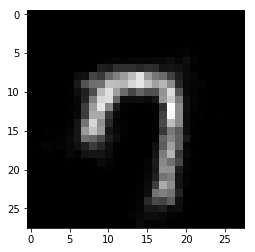

In [85]:
z = torch.tensor([0.5,0.5,0.5,0.5,0.5]).cuda()
ans = model.decode(z)
ans = ans.reshape((28,28))
plt.imshow(ans.cpu().detach().numpy(), cmap="gray")

In [55]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
    for epoch in range(1, 10):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')